In [16]:
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
df = pd.read_csv('./Data/final_merged_normalized_discretized.csv', index_col=0)
df.head()

,CD,Year,Month,dirty_level,Count311_pp,fs_openhours,trs_permits,total_number_of_households,hh_compost_percent,wfr_avg_recycling,...,paper_baskets_sqmi,mgp_baskets_sqmi,seasonal_wire_litter_basket_sqmi,highend_basket_sqmi,publicspacereceptacle_sqmi,wire_basket_sqmi,total_litter_baskets_sqmi,fs_open_sqmi,restaurant_sqmi,business_sqmi
0,BK01,2016,11,2,0.000289,333.25,14.0,92610,0.105226,1.0,...,1.904491,1.904491,0.0,0.42322,0.21161,2.116101,2.962542,1.269661,45.919401,208.224379
1,BK01,2016,12,1,0.000208,333.25,14.0,92610,0.105226,1.0,...,1.904491,1.904491,0.0,0.42322,0.21161,2.116101,2.962542,1.269661,45.919401,193.623279
2,BK01,2017,1,2,0.000295,333.25,14.0,92610,0.105226,1.0,...,1.904491,1.904491,0.0,0.42322,0.21161,2.116101,2.962542,1.269661,45.919401,194.892940
3,BK01,2017,2,2,0.000352,333.25,14.0,92610,0.105226,1.0,...,1.904491,1.904491,0.0,0.42322,0.21161,2.116101,2.962542,1.269661,45.919401,185.582094
4,BK01,2017,3,2,0.000387,333.25,14.0,92610,0.105226,1.0,...,1.904491,1.904491,0.0,0.42322,0.21161,2.116101,2.962542,1.269661,45.919401,187.486585


In [8]:
df.drop(['CD', 'Year', 'Month'], axis=1, inplace=True)

### Define scoring function

In [38]:
from sklearn.metrics import roc_auc_score, classification_report, f1_score, recall_score, precision_score

In [40]:
# create blank df to which we can concat scores 
all_scores = pd.DataFrame(columns=['model', 'acc', 'auc', 'rec', 'prec', 'f-value', 'comment'])
all_scores.to_csv('model_all_scores.csv')

In [73]:
def scoring_table(model, model_name, multi_class, comment):
  # model: model object e.g. of type SVC 
  # model_name: str of model name 
  # multi_class: ovr or ovo 
  # comment: model parameters
  
  # scoring parameters included are 
  # accuracy, auc (multi_class specified by user), recall, precision (both macro - unweighted mean),  
  
  global X_test
  global y_test

  all_scores = pd.read_csv('model_all_scores.csv', index_col=0)

  # get predictions
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)

  # accuracy
  acc = round(model.score(X_test,y_test),4)

  # auc roc 
  auc = round(roc_auc_score(y_test,y_pred_proba, multi_class=multi_class),4)

  # recall
  rec = round(recall_score(y_test,y_pred, average='macro'),4)

  # precision
  prec = round(precision_score(y_test,y_pred, average='macro'),4)

  # f1
  f1 = round(f1_score(y_test,y_pred,  average='macro'),4)

  scores = pd.DataFrame([str(model_name), acc, auc, rec, prec, f1, str(comment)]).T
  scores.columns = all_scores.columns

  all_scores = pd.concat([all_scores,scores], axis=0, ignore_index=True)
  
  all_scores.to_csv('model_all_scores.csv')
  return all_scores

## Train test split

In [22]:
y = df['dirty_level']
X = df.drop('dirty_level', axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

## GridSearchCV

In [26]:
clf = svm.SVC(random_state=99)
clf.fit(X_train, y_train)

SVC(random_state=99)

In [27]:
param_grid = {'C': [np.exp(i) for i in np.linspace(-5,5,100)],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['sigmoid', 'rbf'],
              'decision_function_shape': ['ovo', 'ovr']}

clf = svm.SVC(random_state=99)
grid = GridSearchCV(clf, param_grid=param_grid, cv=5, refit = True)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=99),
             param_grid={'C': [0.006737946999085467, 0.0074541086721749295,
                               0.008246389605637307, 0.009122880349438393,
                               0.010092531380432784, 0.011165244502115052,
                               0.01235197395905096, 0.013664838298540717,
                               0.01511724412181421, 0.016724022988470442,
                               0.018501582872190996, 0.020468075714350484,
                               0.02264358278653442, 0.02505031975...
                               0.03391701802782724, 0.03752198381047752,
                               0.04151011353411509, 0.045922132857324396,
                               0.050803096080009554, 0.05620284622522774,
                               0.06217652402211632, 0.06878513098750348,
                               0.07609615235623413, 0.08418424622139925,
                               0.09313200592177617, 0.1030308034

In [28]:
grid.best_params_

{'C': 54.04942954924472,
 'decision_function_shape': 'ovo',
 'gamma': 0.001,
 'kernel': 'rbf'}

In [30]:
grid.best_estimator_

SVC(C=54.04942954924472, decision_function_shape='ovo', gamma=0.001,
    random_state=99)

In [31]:
from sklearn.metrics import classification_report
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.66      0.69       241
           2       0.50      0.53      0.51       224
           3       0.73      0.75      0.74       232

    accuracy                           0.65       697
   macro avg       0.65      0.65      0.65       697
weighted avg       0.65      0.65      0.65       697



In [67]:
clf = svm.SVC(kernel = 'rbf', C=54.04942954924472, decision_function_shape='ovo', gamma=0.001,
              random_state=99, probability=True)

clf.fit(X_train, y_train)

SVC(C=54.04942954924472, decision_function_shape='ovo', gamma=0.001,
    probability=True, random_state=99)

In [75]:
scoring_table(clf, 'svm', 'ovo', str(grid.best_params_))

,model,acc,auc,rec,prec,f-value,comment
0,svm,0.6485,0.803,0.6469,0.6495,0.6477,"{'C': 54.04942954924472, 'decision_function_sh..."


In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def c_matrix(test, pred, title, filename):
  f, ax = plt.subplots(figsize=(7, 5))
  sns.heatmap(confusion_matrix(test, pred),
              annot=True, 
              fmt="d", 
              linewidths=.5, 
              xticklabels=('0','1'),
              yticklabels=('0','1'),
              cmap="YlGnBu").set(title=str(title))
  
  plt.savefig(str(filename), dpi=400)

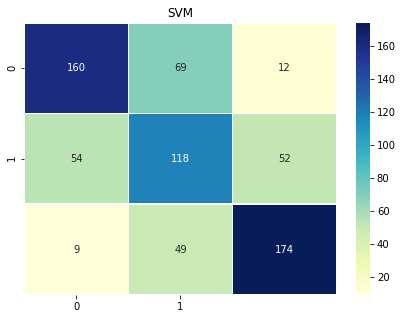

In [34]:
c_matrix(y_test, y_pred, 'SVM', 'svm-tuned-output.png')

In [37]:
y.value_counts()

1    1162
3    1160
2    1159
Name: dirty_level, dtype: int64